In [6]:
import pandas as pd
import glob

# CSV 파일 경로 매칭
file_paths = glob.glob('/Users/changmookoh/Downloads/hunger_datas/data*.csv')

# 모든 파일 읽어서 하나의 DataFrame으로 합치기
df_list = [pd.read_csv(fp) for fp in file_paths]
df = pd.concat(df_list, ignore_index=True)

print(df.shape)        # (예: (2634, 4))
print(df.head())


(2514, 4)
         name            timestamp  heart_rate  label
0  guk il kim  2025-04-02 10:54:20        73.0      0
1  guk il kim  2025-04-02 10:54:30        73.0      0
2  guk il kim  2025-04-02 10:54:40        73.0      0
3  guk il kim  2025-04-02 10:54:50        73.0      0
4  guk il kim  2025-04-02 10:55:00        73.0      0


In [7]:
# 1) 타임스탬프(datetime) 변환
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 2) 결측치 처리 (필요 시)
df = df.dropna(subset=['heart_rate', 'label'])

# 3) 심박수 이상치 제거 (예: 30~200 bpm 범위 외)
df = df[(df['heart_rate'] >= 30) & (df['heart_rate'] <= 200)]


In [8]:
# 윈도우 크기: 예를 들어 1분(=6개 샘플, 10초 간격)으로 설정
window_size = 6

# rolling 특징: 평균, 표준편차, 최대/최소
df = df.sort_values('timestamp')
df['hr_mean'] = df['heart_rate'].rolling(window=window_size).mean()
df['hr_std']  = df['heart_rate'].rolling(window=window_size).std()
df['hr_max']  = df['heart_rate'].rolling(window=window_size).max()
df['hr_min']  = df['heart_rate'].rolling(window=window_size).min()

# 시간 기반 특징: 하루 중 시간(초 단위)
df['seconds_in_day'] = df['timestamp'].dt.hour * 3600 + df['timestamp'].dt.minute * 60 + df['timestamp'].dt.second

# 결과에서 NaN 제거
df = df.dropna(subset=['hr_mean','hr_std','hr_max','hr_min'])


In [9]:
from sklearn.model_selection import train_test_split

# 사용할 특징(피처)와 타깃 레이블
feature_cols = ['hr_mean', 'hr_std', 'hr_max', 'hr_min', 'seconds_in_day']
X = df[feature_cols]
y = df['label']

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 모델 초기화 및 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       141
           1       1.00      1.00      1.00       361

    accuracy                           1.00       502
   macro avg       1.00      1.00      1.00       502
weighted avg       1.00      1.00      1.00       502

Confusion Matrix:
 [[141   0]
 [  0 361]]


In [11]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 예시: 윈도우 길이 W, 피처 개수 F
W = window_size
F = len(feature_cols)

# 윈도우 단위 샘플 생성 (여기서는 간단 예시)
X_seq, y_seq = [], []
for i in range(len(df) - W):
    X_seq.append(df[feature_cols].iloc[i:i+W].values)
    y_seq.append(df['label'].iloc[i+W])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# 학습/검증 분할
split = int(0.8 * len(X_seq))
X_tr, X_val = X_seq[:split], X_seq[split:]
y_tr, y_val = y_seq[:split], y_seq[split:]

# LSTM 모델 구성
model = Sequential([
    LSTM(32, input_shape=(W, F), return_sequences=False),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7091 - loss: 0.6409 - val_accuracy: 0.7964 - val_loss: 0.5542
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7055 - loss: 0.6107 - val_accuracy: 0.7964 - val_loss: 0.5347
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6906 - loss: 0.6187 - val_accuracy: 0.7964 - val_loss: 0.5298
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7034 - loss: 0.6082 - val_accuracy: 0.7964 - val_loss: 0.5286
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6930 - loss: 0.6170 - val_accuracy: 0.7964 - val_loss: 0.5277
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6909 - loss: 0.6188 - val_accuracy: 0.7964 - val_loss: 0.5274
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7087 - loss: 0.6036 - val_accuracy: 0.7964 - val_loss: 0.5259
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7001 - loss: 0.6110 - val_accuracy: 0.7964 - val_loss: 0.5266
Epo

In [12]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Stratified K-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='f1',          # F1-score 기준으로 최적화
    n_jobs=-1,
    verbose=2
)

# 수행
grid.fit(X_train, y_train)

# 베스트 파라미터 및 점수
print("Best params:", grid.best_params_)
print("Best F1-score:", grid.best_score_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_sa

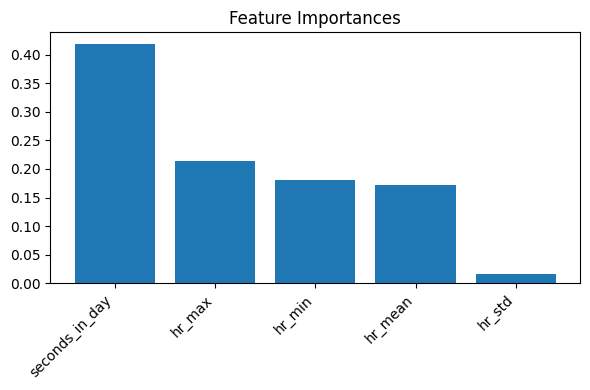

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 최적 모델
best_model = grid.best_estimator_

# 중요도 추출
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = np.array(feature_cols)[indices]

# 막대그래프로 표시
plt.figure(figsize=(6,4))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), features, rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [14]:
# 셀 1: 현재 노트북의 작업 디렉토리를 확인
import os
print("현재 작업 디렉토리:", os.getcwd())


현재 작업 디렉토리: /Users/changmookoh/Desktop


In [2]:
# 셀 2: 내 프로젝트 디렉토리(예: ~/my_project)로 이동
import os
%cd ~/Desktop
print("이제 작업 경로:", os.getcwd())


/Users/changmookoh/Desktop
이제 작업 경로: /Users/changmookoh/Desktop


In [3]:
model_dir = os.path.join(os.getcwd(), 'models')
os.makedirs(model_dir, exist_ok=True)
print("models 폴더가 만들어진 경로:", model_dir)

models 폴더가 만들어진 경로: /Users/changmookoh/Desktop/models


In [20]:
import joblib

# 모델 저장
joblib.dump(best_model, 'hr_hunger_classifier.pkl')

# 나중에 로드
loaded_model = joblib.load('hr_hunger_classifier.pkl')


In [21]:
import joblib
saved_paths = joblib.dump(best_model, 'hr_hunger_classifier.pkl')
print("모델 저장 경로:", saved_paths)


모델 저장 경로: ['hr_hunger_classifier.pkl']


In [22]:
print("디렉토리 내 파일:", os.listdir(os.getcwd()))


디렉토리 내 파일: ['oh_changmook_hw4.zip', 'changmook_oh_hw3.2.pdf', 'goggles.csv', 'Crypto', '1905.03674v3.pdf', '.DS_Store', 'oh_changmook_hw3.zip', '2024.docx', 'changmook_oh_hw3.2.docx', 'ChangmookOh_HW1.docx', 'Untitled-1.ipynb', '화면 기록 2024-06-15 오전 2.24.58.mov', '~$greedy algorithm makes a locally optimal choice at each step in hopes of finding the global optimum.docx', 'CSCI 578', '.localized', 'Programació I Exam.pdf', '창의설계', 'A greedy algorithm makes a locally optimal choice at each step in hopes of finding the global optimum.pdf', '123.jpeg', 'changmook_oh_hw2.2.pdf', 'KimTest', 'bbk-nesta-ci', 'Test2.pdf', 'A greedy algorithm makes a locally optimal choice at each step in hopes of finding the global optimum.docx', '11.pdf', '화면 기록 2024-06-15 오전 2.37.45.mov', '김예진 2월달 여행 루트.pdf', 'models', 'changmook_oh_hw4.2.pdf', 'Screenshot 2025-04-11 at 10.54.28\u202fPM.png', '김예진 2월달 여행 루트.docx', 'Proportionally Fair Clustering.pdf', 'Chang

In [16]:
from collections import deque
import numpy as np

# 슬라이딩 윈도우용 버퍼 생성
window_size = 6
buffer = deque(maxlen=window_size)

def predict_hunger(new_hr, timestamp, model, scaler=None):
    """
    새로운 심박수를 받고, 슬라이딩 윈도우 기반으로 배고픔 예측.
    
    Args:
      new_hr: float, 최신 심박수
      timestamp: datetime, 측정 시각
      model: 학습된 classifier
      scaler: (선택) sklearn scaler 객체
    
    Returns:
      pred: 0 or 1
    """
    # 버퍼에 추가
    buffer.append((new_hr, timestamp))
    if len(buffer) < window_size:
        return None  # 충분한 데이터 부족
    
    # DataFrame 변환
    tmp = pd.DataFrame(buffer, columns=['heart_rate','timestamp'])
    # 특징 계산
    hr_mean = tmp['heart_rate'].mean()
    hr_std  = tmp['heart_rate'].std()
    hr_max  = tmp['heart_rate'].max()
    hr_min  = tmp['heart_rate'].min()
    secs    = (tmp['timestamp'].dt.hour * 3600 +
               tmp['timestamp'].dt.minute * 60 +
               tmp['timestamp'].dt.second).mean()  # 평균 시간
    
    feat = np.array([[hr_mean, hr_std, hr_max, hr_min, secs]])
    if scaler:
        feat = scaler.transform(feat)
    # 예측
    pred = model.predict(feat)[0]
    return pred

# 사용 예시
from datetime import datetime
res = predict_hunger(72.0, datetime.now(), loaded_model)
if res is not None:
    print("배고픔 상태:", "배고픔" if res==1 else "안 배고픔")
else:
    print("윈도우에 데이터가 더 필요합니다.")


윈도우에 데이터가 더 필요합니다.


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(**grid.best_params_, random_state=42))
])

# 파이프라인 학습
pipe.fit(X_train, y_train)

# 평가
print(classification_report(y_test, pipe.predict(X_test)))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       141
           1       1.00      1.00      1.00       361

    accuracy                           1.00       502
   macro avg       1.00      1.00      1.00       502
weighted avg       1.00      1.00      1.00       502



In [23]:
import joblib
model_path = '/Users/changmookoh/Desktop/hr_hunger_classifier.pkl'  # 실제 경로를 지정
pipe = joblib.load(model_path)


In [24]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe, X, y, cv=5, scoring='f1')
print("5-fold CV F1 scores:", scores)


5-fold CV F1 scores: [0.8499336  0.70928463 0.93774834 0.75172414 0.86778846]


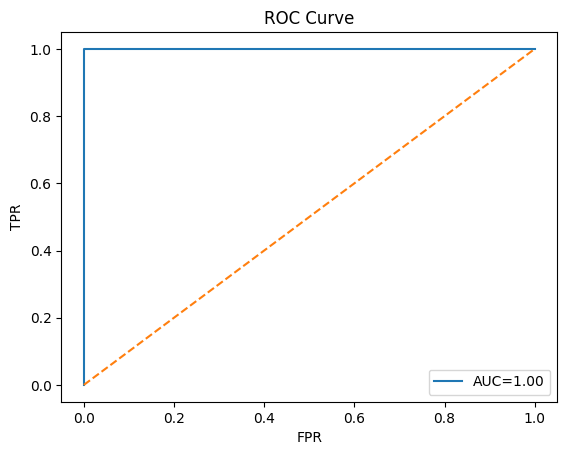

In [25]:
from sklearn.metrics import roc_curve, auc
y_prob = pipe.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
# 원하는 균형점을 찾아서 threshold를 설정


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ('scaler', StandardScaler()),                         # 1) 피처 스케일링
    ('clf', RandomForestClassifier(
        **grid.best_params_,  # 예: {'n_estimators':100, 'max_depth':10, …}
        random_state=42
    ))
])


In [28]:
# 파라미터 덩어리 보기
for k, v in pipe.get_params().items():
    if k.startswith('clf__'):   # clf__ 로 시작하는 건 RandomForest의 파라미터
        print(k, v)


clf__bootstrap True
clf__ccp_alpha 0.0
clf__class_weight None
clf__criterion gini
clf__max_depth None
clf__max_features sqrt
clf__max_leaf_nodes None
clf__max_samples None
clf__min_impurity_decrease 0.0
clf__min_samples_leaf 1
clf__min_samples_split 2
clf__min_weight_fraction_leaf 0.0
clf__monotonic_cst None
clf__n_estimators 100
clf__n_jobs None
clf__oob_score False
clf__random_state 42
clf__verbose 0
clf__warm_start False


In [30]:
!pip install pandas numpy scipy scikit-learn imbalanced-learn lightgbm joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.1 MB/s eta 0:00:00


In [32]:
# 1) Data Load & Preprocessing
import glob, os
import pandas as pd
import numpy as np

# CSV 합치기
files = glob.glob('/Users/changmookoh/Downloads/hunger_datas/data*.csv')  # 로컬에서는 경로를 바꿔 주세요
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.dropna(subset=['heart_rate','label'])
df = df[(df['heart_rate']>=30)&(df['heart_rate']<=200)]
df = df.sort_values('timestamp').reset_index(drop=True)

# 2) 윈도우 기반 피처 추출 함수
from scipy.signal import welch

def extract_features(win: pd.DataFrame):
    hr = win['heart_rate'].values
    # RR interval (s)
    rr = 60.0 / hr
    diffs = np.diff(rr)
    feats = {
        # 기본 통계
        'hr_mean': hr.mean(),
        'hr_std' : hr.std(),
        'hr_max' : hr.max(),
        'hr_min' : hr.min(),
        # HRV 시간 영역
        'rmssd'  : np.sqrt(np.mean(diffs**2)),
        'sdnn'   : rr.std(),
        'pnn50'  : np.sum(np.abs(diffs) > 0.05) / len(diffs),
    }
    # HRV 주파수 영역 (Welch)
    # 샘플링 주파수 (Hz) = 1 / (평균 샘플 간격)
    fs = 1.0 / np.mean(np.diff(win['timestamp'].astype(np.int64)/1e9))
    fxx, pxx = welch(rr, fs=fs, nperseg=len(rr))
    lf = pxx[(fxx>=0.04)&(fxx<0.15)].sum()
    hf = pxx[(fxx>=0.15)&(fxx<0.4)].sum()
    feats['lf_hf'] = lf/hf if hf>0 else 0.0
    # 순환 시간 특성
    secs = (win['timestamp'].dt.hour*3600 +
            win['timestamp'].dt.minute*60 +
            win['timestamp'].dt.second)
    angle = 2*np.pi*secs.mean()/86400
    feats['sin_time'] = np.sin(angle)
    feats['cos_time'] = np.cos(angle)
    return feats

# 3) 윈도우 슬라이딩으로 X, y 구성
window_size = 6
X_list, y_list = [], []
for i in range(window_size-1, len(df)):
    win = df.iloc[i-window_size+1:i+1]
    X_list.append(extract_features(win))
    y_list.append(df['label'].iloc[i])

X = pd.DataFrame(X_list)
y = np.array(y_list)

# 4) Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5) Pipeline 구성 (SMOTE → Scaling → LightGBM)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier

pipe = imPipeline([
    ('smote',   SMOTE(random_state=42)),
    ('scaler',  StandardScaler()),
    ('clf',     LGBMClassifier(random_state=42))
])

# 6) Hyperparameter Search (RandomizedSearchCV)
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

param_dist = {
    'clf__n_estimators':   [50, 100, 200, 500],
    'clf__learning_rate':  [0.01, 0.05, 0.1],
    'clf__num_leaves':     [31, 50, 100],
    'clf__subsample':      [0.6, 0.8, 1.0],
    'clf__colsample_bytree':[0.6, 0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    pipe, param_dist, n_iter=30,
    scoring='f1', cv=cv,
    n_jobs=-1, random_state=42, verbose=2
)
search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("CV Best F1:", search.best_score_)

best_model = search.best_estimator_

# 7) Test 평가
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# 8) 모델 캘리브레이션
from sklearn.calibration import CalibratedClassifierCV
calib = CalibratedClassifierCV(best_model, cv=cv, method='sigmoid')
calib.fit(X_train, y_train)
y_calib = calib.predict(X_test)
print("=== Calibrated ===")
print(classification_report(y_test, y_calib))

# 9) 저장하기
import joblib
os.makedirs('models', exist_ok=True)
joblib.dump(calib, 'models/hr_hunger_calibrated_lgbm.pkl')
print("Saved to models/hr_hunger_calibrated_lgbm.pkl")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Auto-choosing row-wise multi-threading,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[Light

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positiv

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.01, clf__n_estimators=200, clf__num_leaves=100, clf__subsample=0.6; total time=  23.0s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.01, clf__n_estimators=200, clf__num_leaves=100, clf__subsample=0.6; total time=  23.2s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive:

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.01, clf__n_estimators=200, clf__num_leaves=100, clf__subsample=0.6; total time=  23.5s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.01, clf__n_estimators=200, clf__num_leaves=100, clf__subsample=0.6; total time=  23.7s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gai

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.01, clf__n_estimators=500, clf__num_leaves=31, clf__subsample=1.0; total time=  23.0s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1209
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.01, clf__n_estimators=500, clf__num_leaves=31, clf__subsample=1.0; total time=  23.4s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.01, clf__n_estimators=500, clf__num_leaves=31, clf__subsample=1.0; total time=  23.4s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.01, clf__n_estimators=500, clf__num_leaves=31, clf__subsample=1.0; total time=  23.7s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_row_wise=true` to remov

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.1, clf__n_estimators=50, clf__num_leaves=31, clf__subsample=0.6; total time=   2.5s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1209
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/

[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.1, clf__n_estimators=50, clf__num_leaves=31, clf__subsample=0.6; total time=   2.4s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.1, clf__n_estimators=50, clf__num_leaves=31, clf__subsample=0.6; total time=   2.7s
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.1, clf__n_estimators=50, clf__num_leaves=31, clf__subsample=0.6; total time=   2.4s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.6; total time=   5.4s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.01, clf__n_estimators=50, clf__num_leaves=50, clf__subsample=0.6; total time=   3.8s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1218

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.01, clf__n_estimators=50, clf__num_leaves=50, clf__subsample=0.6; total time=   3.8s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wis

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.01, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.6; total time=   9.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1209
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.01, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=0.6; total time=   9.6s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.1, clf__n_estimators=100, clf__num_leaves=100, clf__subsample=0.8; total time=  12.6s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__n_estimators=100, clf__num_leaves=50, clf__subsample=1.0; total time=   7.1s
[LightGBM] [Warning] No further splits with positive gain, best g

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.1, clf__n_estimators=100, clf__num_leaves=100, clf__subsample=0.8; total time=  13.1s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__n_estimators=50, clf__num_leaves=31, clf__subsample=0.6; total time=   2.2s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1209
[LightGBM] [Info] Number of data points in the train set: 2312, numb

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   9.1s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   9.2s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=  10.1s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8; total time=   4.4s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8; total time=   5.2s
[LightGBM] [Info] Number of posi

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=100, clf__subsample=0.8; total time=  11.1s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1209
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__n_estimators=500, clf__num_leaves=100, clf__subsample=1.0; total time=  34.0s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__n_estimators=100, clf__num_leaves=50, clf__subsample=1.0; total time=   7.7s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__n_estimators=50, clf__num_leaves=100, clf__subsample=1.0; total time=   5.3s
[LightGBM] [Info] Number of posit

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1209
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-thre

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__n_estimators=100, clf__num_leaves=50, clf__subsample=1.0; total time=   7.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=50, clf__num_leaves=50, clf__subsample=1.0; total time=   4.0s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=50, clf__num_leaves=50, clf__subsample=1.0; total time=   4.0s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 2312, number of used 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=50, clf__num_leaves=50, clf__subsample=1.0; total time=   4.0s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=200, clf__num_leaves=100, clf__subsample=0.8; total time=  22.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 2312, number of use

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__n_estimators=200, clf__num_leaves=100, clf__subsample=0.8; total time=  15.6s
[LightGBM] [Warning] No further 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=200, clf__num_leaves=100, clf__subsample=0.8; total time=  24.0s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003143 seconds.
You can 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=200, clf__num_leaves=100, clf__subsample=0.8; total time=  24.1s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8; total time=   5.3s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1209
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8; total time=   5.3s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [In

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8; total time=   5.2s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8; total time=   5.2s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002415 seconds.
You can set `force_col_wise=true` to remov

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   9.2s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8; total time=   5.3s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1209
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   9.0s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   9.3s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__n_estimators=200, clf__num_leaves=31, clf__subsample=1.0; total time=   9.3s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.1, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8; total time=   5.1s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1209
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.1, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8; total time=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.1, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8; total time=   5.0s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.1, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8; total time=   5.2s
[LightGBM] [Info] Number of positive: 1156, number of negative: 115

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__n_estimators=100, clf__num_leaves=50, clf__subsample=0.8; total time=   7.4s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.1, clf__n_estimators=200, clf__num_leaves=50, clf__subsample=0.6; total time=  11.9s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.1, clf__n_estimators=200, clf__num_leaves=50, clf__subsample=0.6; total time=  11.9s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_b

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.1, clf__n_estimators=500, clf__num_leaves=31, clf__subsample=1.0; total time=   9.9s
[LightGBM] [Info] Number of positive: 1156, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> ini

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=500, clf__num_leaves=31, clf__subsample=0.6; total time=  16.2s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=500, clf__num_leaves=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/

In [35]:
import glob
import os
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import SelfTrainingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# -------- CONFIG --------
# 라벨된 CSV (data1.csv ~ data6.csv) 경로 패턴
labeled_glob = "/Users/changmookoh/Downloads/hunger_datas/data*.csv"
# 라벨 없는 CSV 폴더 (per-day 윈도우 CSV) 경로
unlabeled_dir = "/Users/changmookoh/Desktop/daily_meals_interp"
# 슬라이딩 윈도우 크기
window_size = 6
# ------------------------

def extract_features_from_window(df_win):
    """윈도우(df_win)에 대해 hr_mean, hr_std, hr_max, hr_min, secs_mean 추출"""
    hrs = df_win['heart_rate'].values
    ts = pd.to_datetime(df_win['timestamp'])
    secs = ts.dt.hour * 3600 + ts.dt.minute * 60 + ts.dt.second
    return [
        hrs.mean(),
        hrs.std(),
        hrs.max(),
        hrs.min(),
        secs.mean()
    ]

# 1) 라벨된 데이터 처리
X_lab, y_lab = [], []
for fp in glob.glob(labeled_glob):
    df = pd.read_csv(fp)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    for i in range(window_size - 1, len(df)):
        win = df.iloc[i-window_size+1:i+1]
        # 결측치나 이상치 처리 생략
        feats = extract_features_from_window(win)
        X_lab.append(feats)
        y_lab.append(df.loc[i, 'label'])

# 2) 라벨 없는 데이터 처리
X_unlab, y_unlab = [], []
for fn in os.listdir(unlabeled_dir):
    if not fn.endswith(".csv"):
        continue
    df = pd.read_csv(os.path.join(unlabeled_dir, fn))
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    for i in range(window_size - 1, len(df)):
        win = df.iloc[i-window_size+1:i+1]
        feats = extract_features_from_window(win)
        X_unlab.append(feats)
        y_unlab.append(-1)

# 배열 변환
X_lab = np.array(X_lab)
y_lab = np.array(y_lab)
X_unlab = np.array(X_unlab)
y_unlab = np.array(y_unlab)

# 학습용 결합
X_comb = np.vstack([X_lab, X_unlab])
y_comb = np.concatenate([y_lab, y_unlab])

# 3) Self-training
base_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LGBMClassifier(n_estimators=100, random_state=42))
])
self_training = SelfTrainingClassifier(
    base_pipe,
    criterion='threshold',  # 'probability' → 'threshold' 로 변경
    threshold=0.8,
    max_iter=10
)
self_training.fit(X_comb, y_comb)

# 4) 평가 (원래 테스트 데이터 분리해두었다면 여기서 평가)
# 예시로 labeled 데이터 일부를 다시 평가
y_pred = self_training.predict(X_lab)
print(classification_report(y_lab, y_pred))


[LightGBM] [Info] Number of positive: 1806, number of negative: 678
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 586
[LightGBM] [Info] Number of data points in the train set: 2484, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.727053 -> initscore=0.979722
[LightGBM] [Info] Start training from score 0.979722


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 211107, number of negative: 340035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 551142, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383036 -> initscore=-0.476683
[LightGBM] [Info] Start training from score -0.476683


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 228029, number of negative: 433785
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 661814, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.344551 -> initscore=-0.643076
[LightGBM] [Info] Start training from score -0.643076


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 228399, number of negative: 434306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 662705, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.344647 -> initscore=-0.642655
[LightGBM] [Info] Start training from score -0.642655


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 228507, number of negative: 434377
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 662884, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.344716 -> initscore=-0.642346
[LightGBM] [Info] Start training from score -0.642346


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 228550, number of negative: 434406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 662956, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.344744 -> initscore=-0.642225
[LightGBM] [Info] Start training from score -0.642225


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 228555, number of negative: 434407
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 662962, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.344748 -> initscore=-0.642205
[LightGBM] [Info] Start training from score -0.642205


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 228561, number of negative: 434410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 662971, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.344753 -> initscore=-0.642186
[LightGBM] [Info] Start training from score -0.642186


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 228561, number of negative: 434410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 662971, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.344753 -> initscore=-0.642186
[LightGBM] [Info] Start training from score -0.642186
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       678
           1       0.97      1.00      0.98      1806

    accuracy                           0.97      2484
   macro avg       0.98      0.95      0.97      2484
weighted avg       0.97      0.97      0.97      2484



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [36]:
import glob
import os
import numpy as np
import pandas as pd
from datetime import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# -------- CONFIG --------
labeled_glob = "/Users/changmookoh/Downloads/hunger_datas/data*.csv"
unlabeled_dir = "/Users/changmookoh/Desktop/daily_meals_interp"
window_size = 6
pseudo_threshold_high = 0.9
pseudo_threshold_low  = 0.1
# ------------------------

def load_sequences(path_list, label_for_path=None):
    """
    path_list: csv 파일 경로 리스트
    label_for_path: None이면 unlabeled, 아니면 함수(df)→0/1 리턴
    반환: X (N, window_size, 1), y (N,)   (y는 None or array)
    """
    Xs, ys = [], []
    for fp in path_list:
        df = pd.read_csv(fp)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp').reset_index(drop=True)
        hr = df['heart_rate'].values
        for i in range(window_size-1, len(hr)):
            window = hr[i-window_size+1:i+1]
            Xs.append(window.reshape(-1,1))
            if label_for_path is None:
                ys.append(-1)
            else:
                ys.append(label_for_path(df, i))
    X = np.stack(Xs, axis=0)
    y = np.array(ys) if ys[0] is not None else None
    return X, y

# 1) labeled 데이터 로드
label_func = lambda df,i: int(df.loc[i,'label'])  # 0 또는 1
labeled_paths = glob.glob(labeled_glob)
X_lab, y_lab = load_sequences(labeled_paths, label_for_path=label_func)

# 2) unlabeled 데이터 로드
unlabeled_paths = [os.path.join(unlabeled_dir,f)
                   for f in os.listdir(unlabeled_dir) if f.endswith(".csv")]
X_unlab, _ = load_sequences(unlabeled_paths, label_for_path=None)

# 3) LSTM 모델 정의 & 초기 학습
model = Sequential([
    LSTM(64, input_shape=(window_size,1)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# train/val split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_lab, y_lab, test_size=0.1, stratify=y_lab, random_state=42)

model.fit(X_tr, y_tr,
          validation_data=(X_val,y_val),
          epochs=20, batch_size=32)

# 4) unlabeled에 대한 pseudo-label 생성
probs_unlab = model.predict(X_unlab).flatten()
mask_high = probs_unlab >= pseudo_threshold_high
mask_low  = probs_unlab <= pseudo_threshold_low

X_pseudo = X_unlab[mask_high | mask_low]
y_pseudo = (probs_unlab[mask_high | mask_low] >= 0.5).astype(int)

print(f"Pseudo labeled samples: {len(y_pseudo)}")

# 5) 원본 + pseudo 합쳐서 재학습
X_comb = np.concatenate([X_lab, X_pseudo], axis=0)
y_comb = np.concatenate([y_lab, y_pseudo], axis=0)

# (선택) 다시 train/val split
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
    X_comb, y_comb, test_size=0.1, stratify=y_comb, random_state=42)

model.fit(X_tr2, y_tr2,
          validation_data=(X_val2,y_val2),
          epochs=10, batch_size=32)

# 6) 최종 평가
y_pred = (model.predict(X_val2).flatten() >= 0.5).astype(int)
print(classification_report(y_val2, y_pred))


Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7455 - loss: 0.6040 - val_accuracy: 0.7871 - val_loss: 0.5262
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7737 - loss: 0.5316 - val_accuracy: 0.7912 - val_loss: 0.4930
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7503 - loss: 0.5376 - val_accuracy: 0.7912 - val_loss: 0.4931
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7561 - loss: 0.5129 - val_accuracy: 0.7671 - val_loss: 0.4712
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7575 - loss: 0.5122 - val_accuracy: 0.7631 - val_loss: 0.4681
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7698 - loss: 0.4938 - val_accuracy: 0.7631 - val_loss: 0.4587
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7674 - loss: 0.4957 - val_accuracy: 0.7912 - val_loss: 0.4569
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7696 - loss: 0.4750 - val_accuracy: 0.7751 - val_loss: 0.4478
Epo

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense

model = Sequential([
    Input(shape=(window_size, 1)),            # ← 여기서 Input import 필요
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation='sigmoid')
])


In [41]:
from tensorflow.keras.optimizers import Adam

# 1) 컴파일
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 2) 모델 구조 출력
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 6, 128)         │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,433 (212.63 KB)

 Trainable params: 54,433 (212.63 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# train/validation 데이터 준비 (예시)
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_lab, y_lab, test_size=0.1, stratify=y_lab, random_state=42
)

# 실제 학습
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[  # 옵션: 얼리 스톱핑, LR 감소 등
        # EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        # ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
)


Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7326 - loss: 0.5941 - val_accuracy: 0.7871 - val_loss: 0.5309
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7573 - loss: 0.5308 - val_accuracy: 0.7992 - val_loss: 0.5059
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7603 - loss: 0.5301 - val_accuracy: 0.7751 - val_loss: 0.4816
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7636 - loss: 0.5170 - val_accuracy: 0.7751 - val_loss: 0.4638
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7700 - loss: 0.4942 - val_accuracy: 0.7711 - val_loss: 0.4662
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7595 - loss: 0.4888 - val_accuracy: 0.7992 - val_loss: 0.4527
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7679 - loss: 0.4705 - val_accuracy: 0.7631 - val_loss: 0.4503
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7650 - loss: 0.4727 - val_accuracy: 0.8112 - val_loss:

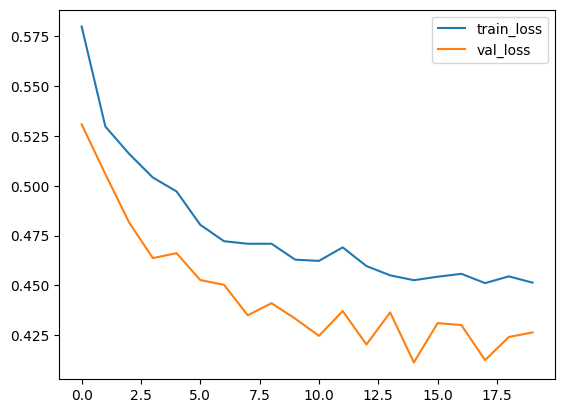

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.show()


In [59]:
import pandas as pd

def predict_day(csv_path, model, window_size=6, threshold=0.5):
    # CSV에 'timestamp'와 'heart_rate' 컬럼이 있다고 가정
    df = pd.read_csv(csv_path, parse_dates=['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    results = []
    for i in range(window_size-1, len(df)):
        window = df['heart_rate'].iloc[i-window_size+1 : i+1].values
        x = window.reshape(1, window_size, 1)
        prob = model.predict(x)[0,0]
        label = int(prob >= threshold)
        results.append({
            'timestamp': df.loc[i, 'timestamp'],
            'hunger_prob': prob,
            'predicted_label': label
        })
    
    return pd.DataFrame(results)

# 사용 예
df_pred = predict_day("/Users/changmookoh/Desktop/daily_meals_interp/changmook_oh_2025-04-12.csv", model)
print(df_pred.head())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [60]:
df_pred.to_csv("hunger_predictions_0412.csv", index=False)

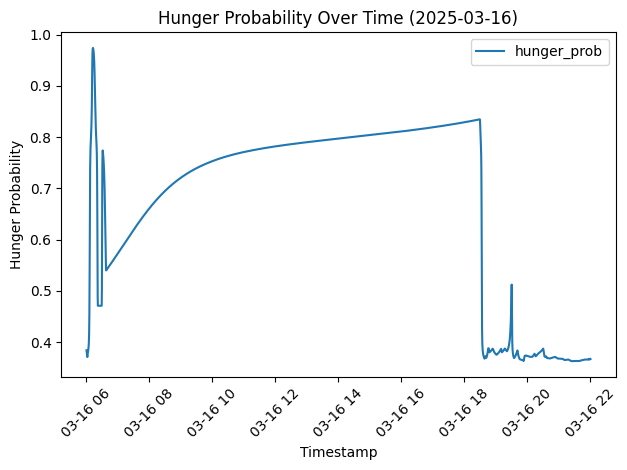

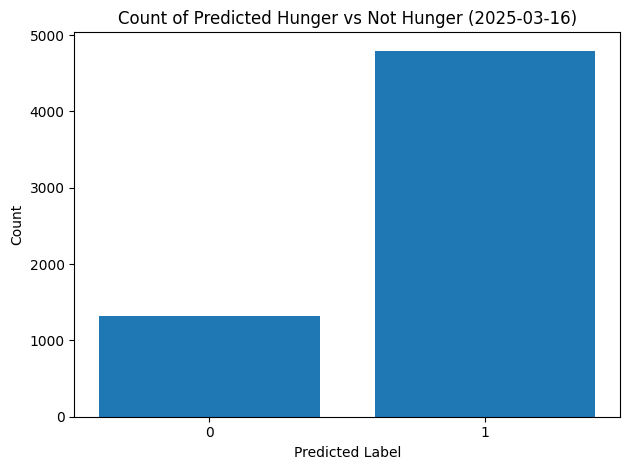

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Load 2025-03-16 prediction data
df0316 = pd.read_csv('/Users/changmookoh/Desktop/hunger_predictions_0316.csv', parse_dates=['timestamp'])

# 1) Hunger probability over time
plt.figure()
plt.plot(df0316['timestamp'], df0316['hunger_prob'], label='hunger_prob')
plt.xlabel('Timestamp')
plt.ylabel('Hunger Probability')
plt.title('Hunger Probability Over Time (2025-03-16)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Count of predicted labels (0 vs 1)
counts = df0316['predicted_label'].value_counts().sort_index()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.title('Count of Predicted Hunger vs Not Hunger (2025-03-16)')
plt.tight_layout()
plt.show()

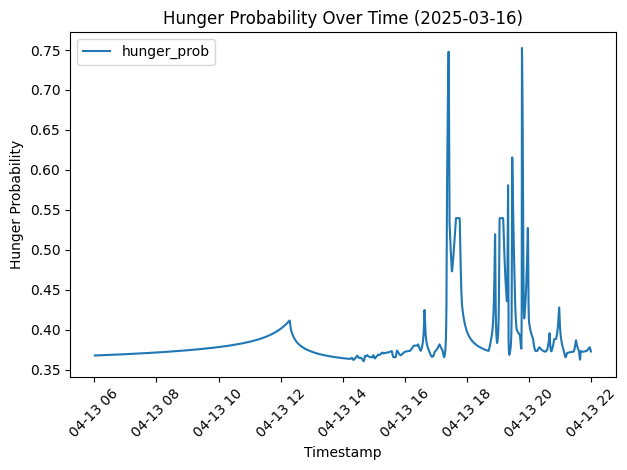

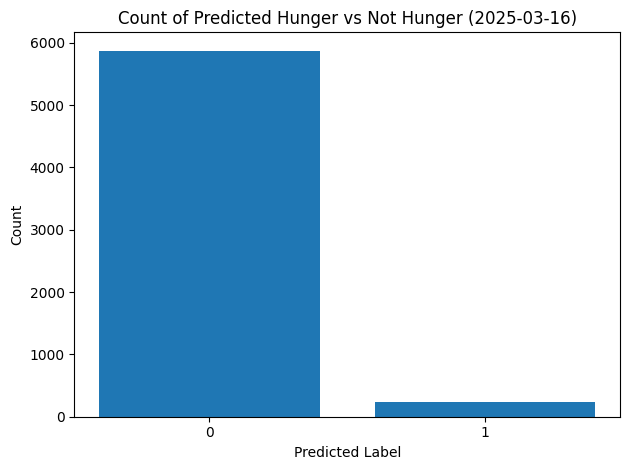

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Load 2025-03-16 prediction data
df0316 = pd.read_csv('/Users/changmookoh/Desktop/hunger_predictions_0413.csv', parse_dates=['timestamp'])

# 1) Hunger probability over time
plt.figure()
plt.plot(df0316['timestamp'], df0316['hunger_prob'], label='hunger_prob')
plt.xlabel('Timestamp')
plt.ylabel('Hunger Probability')
plt.title('Hunger Probability Over Time (2025-03-16)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Count of predicted labels (0 vs 1)
counts = df0316['predicted_label'].value_counts().sort_index()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.title('Count of Predicted Hunger vs Not Hunger (2025-03-16)')
plt.tight_layout()
plt.show()

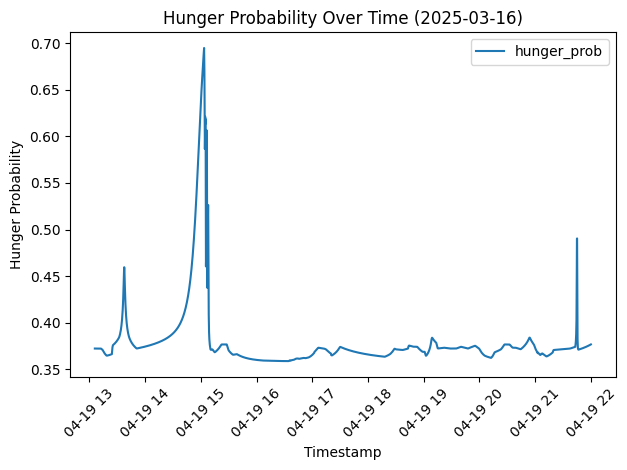

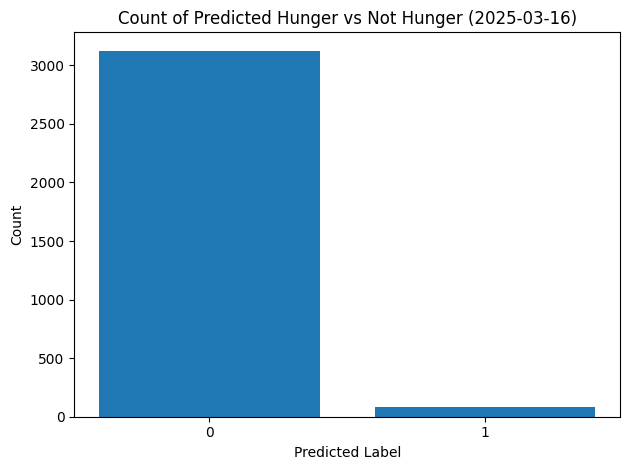

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Load 2025-03-16 prediction data
df0316 = pd.read_csv('/Users/changmookoh/Desktop/hunger_predictions_0419.csv', parse_dates=['timestamp'])

# 1) Hunger probability over time
plt.figure()
plt.plot(df0316['timestamp'], df0316['hunger_prob'], label='hunger_prob')
plt.xlabel('Timestamp')
plt.ylabel('Hunger Probability')
plt.title('Hunger Probability Over Time (2025-03-16)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Count of predicted labels (0 vs 1)
counts = df0316['predicted_label'].value_counts().sort_index()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.title('Count of Predicted Hunger vs Not Hunger (2025-03-16)')
plt.tight_layout()
plt.show()

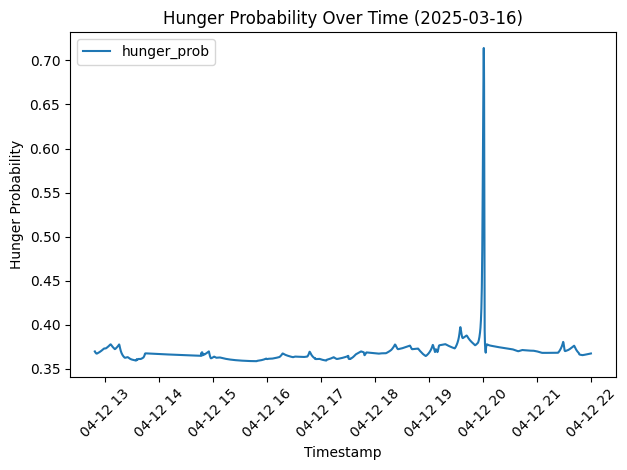

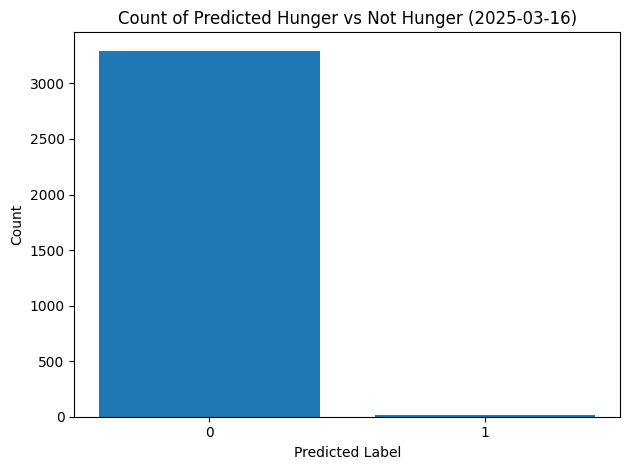

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Load 2025-03-16 prediction data
df0316 = pd.read_csv('/Users/changmookoh/Desktop/hunger_predictions_0412.csv', parse_dates=['timestamp'])

# 1) Hunger probability over time
plt.figure()
plt.plot(df0316['timestamp'], df0316['hunger_prob'], label='hunger_prob')
plt.xlabel('Timestamp')
plt.ylabel('Hunger Probability')
plt.title('Hunger Probability Over Time (2025-03-16)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Count of predicted labels (0 vs 1)
counts = df0316['predicted_label'].value_counts().sort_index()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.title('Count of Predicted Hunger vs Not Hunger (2025-03-16)')
plt.tight_layout()
plt.show()